In [1]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4' 

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator


E0000 00:00:1743958854.267712 1778471 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743958854.271589 1778471 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743958854.283199 1778471 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743958854.283221 1778471 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743958854.283224 1778471 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743958854.283226 1778471 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# GLOBAL VARIABLES
dataset = "animals"
base_dir = os.path.join("datasets", dataset)
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
augmented_dir = os.path.join(base_dir, "aug")
os.makedirs(augmented_dir, exist_ok=True)

models_dir = os.path.join("models", dataset)
os.makedirs(models_dir, exist_ok=True)

metadata_file = os.path.join(models_dir, "metadata.csv")
metrics_file = os.path.join(models_dir, "metrics.csv")

# HYPERPARAMETERS
HYPERPARAMETERS = {
    "model_version": 11,
    # Image processing
    "img_width": 256,
    "img_height": 256,
    "rescale": 1.0 / 255,
    "rotation_range": 10,
    "width_shift_range": 0.2,
    "zoom_range": 0.3,
    "horizontal_flip": True,
    # Training
    "batch_size": 32,
    # Model
    "num_classes": 90,
    "learning_rate": 0.001,
}

epochs = 100

In [4]:
import hashlib

# USING THE HYPERPARAMETERS GENERATE A KEY (HASH)
def generate_hash():
    hash_input = ""
    for key, value in HYPERPARAMETERS.items():
        if isinstance(value, list):
            value = str(value)
        hash_input += f"{key}:{value};"
    # Generate a hash
    return hashlib.md5(hash_input.encode()).hexdigest()

In [5]:
hash_key = generate_hash()

if not os.path.exists(metadata_file):
    cols = ["hash_key"]
    cols.extend(HYPERPARAMETERS.keys())
    metadata = pd.DataFrame(columns=cols)
    metadata.to_csv(metadata_file, index=False)
    
metadata = pd.read_csv(metadata_file)
if hash_key not in metadata["hash_key"].values:
    metadata = pd.read_csv(metadata_file)
    new_row = {**HYPERPARAMETERS, "hash_key": hash_key}
    metadata = pd.concat([metadata, pd.DataFrame([new_row])], ignore_index=True)
    metadata.to_csv(metadata_file, index=False)

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=HYPERPARAMETERS["horizontal_flip"],
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(HYPERPARAMETERS["img_width"], HYPERPARAMETERS["img_height"]),
    batch_size=HYPERPARAMETERS["batch_size"],
    class_mode="binary",
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    class_mode="binary",
    target_size=(HYPERPARAMETERS["img_width"], HYPERPARAMETERS["img_height"]),
    batch_size=20,
)

Found 4320 images belonging to 90 classes.
Found 1080 images belonging to 90 classes.


In [7]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(
    layers.Input(
        shape=(HYPERPARAMETERS["img_width"], HYPERPARAMETERS["img_height"], 3),
    )
)

model.add(
    layers.Conv2D(32, kernel_size=3, activation="relu", padding="same", strides=2)
)
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, kernel_size=5, activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))


model.add(layers.Conv2D(128, kernel_size=5, activation="relu", padding="same"))
model.add(layers.Conv2D(128, kernel_size=5, activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(HYPERPARAMETERS["num_classes"], activation="softmax"))

model.summary()

I0000 00:00:1743958856.503169 1778471 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4084 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 90)             │    11,796,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,464,282 (47.55 MB)

 Trainable params: 12,463,834 (47.55 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(
            models_dir,
            hash_key,
            "{epoch:02d}",
            "model-{loss:.4f}.keras",
        ),
        save_freq=len(train_generator) * 5,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=3,
        min_lr=0.000001,
        min_delta=0.001,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
    ),
]

In [9]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=HYPERPARAMETERS["learning_rate"]),
    metrics=["acc"],
)

In [10]:
histories = []

In [11]:
start_epoch = 0
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    initial_epoch=start_epoch,
    verbose=1,
    callbacks=callbacks,
    validation_data=test_generator,
)

histories.append(history)

/home/cajas/Archivos/tec/semestre_8/tc3002b/ml_benji/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1743958860.026278 1778745 service.cc:152] XLA service 0x7cf238010b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743958860.026304 1778745 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
I0000 00:00:1743958860.419587 1778745 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/135 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - acc: 0.0078 - loss: 9.3666      

I0000 00:00:1743958876.402984 1778745 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - acc: 0.0193 - loss: 15.8244

/home/cajas/Archivos/tec/semestre_8/tc3002b/ml_benji/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


135/135 ━━━━━━━━━━━━━━━━━━━━ 69s 377ms/step - acc: 0.0194 - loss: 15.7950 - val_acc: 0.0102 - val_loss: 13.1769 - learning_rate: 0.0010
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 49s 365ms/step - acc: 0.0471 - loss: 5.9795 - val_acc: 0.0148 - val_loss: 9.3828 - learning_rate: 0.0010
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 49s 361ms/step - acc: 0.0690 - loss: 5.0479 - val_acc: 0.0148 - val_loss: 6.2591 - learning_rate: 0.0010
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 48s 358ms/step - acc: 0.0829 - loss: 4.2718 - val_acc: 0.0657 - val_loss: 4.7755 - learning_rate: 0.0010
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 49s 364ms/step - acc: 0.1037 - loss: 4.1187 - val_acc: 0.0778 - val_loss: 4.2849 - learning_rate: 0.0010
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 51s 378ms/step - acc: 0.1388 - loss: 3.7725 - val_acc: 0.1102 - val_loss: 3.8854 - learning_rate: 0.0010
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - acc: 0.1316 - loss: 3.7193 - val_acc: 0.0389 - val_loss: 21.0922 - learning_

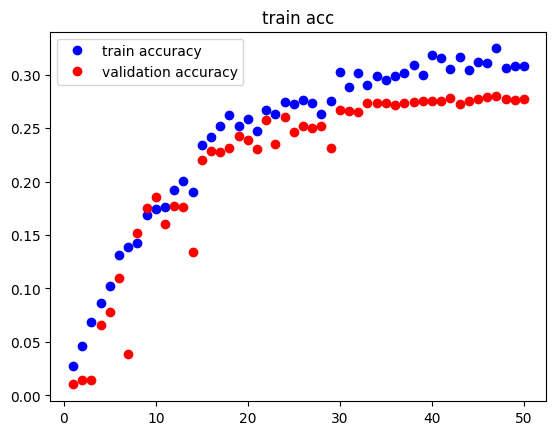

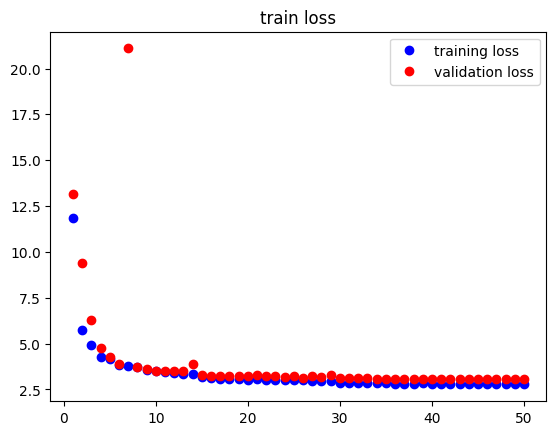

In [14]:
acc = histories[0].history['acc']
for i in range(1, len(histories)):
    acc = np.concatenate((acc, histories[i].history['acc']))

val_acc = histories[0].history['val_acc']
for i in range(1, len(histories)):
    val_acc = np.concatenate((val_acc, histories[i].history['val_acc']))

loss = histories[0].history['loss']
for i in range(1, len(histories)):
    loss = np.concatenate((loss, histories[i].history['loss']))

val_loss = histories[0].history['val_loss']
for i in range(1, len(histories)):
    val_loss = np.concatenate((val_loss, histories[i].history['val_loss']))

epochs_range = range(1, len(acc) + 1)

plt.plot(epochs_range, acc, "bo", label="train accuracy")
plt.plot(epochs_range, val_acc, "ro", label="validation accuracy")
plt.title("train acc")
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, "bo", label="training loss")
plt.plot(epochs_range, val_loss, "ro", label="validation loss")
plt.title("train loss")
plt.legend()

plt.show()

In [13]:
test_generator.reset()
test_loss, test_acc = model.evaluate(test_generator)
print("\ntest acc :\n", test_acc)

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - acc: 0.2854 - loss: 2.9988

test acc :
 0.2768518626689911
